In [141]:
import os
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
import torch
from numpy import random as rand
import torchio as tio
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from typing import Union, Tuple, List
import matplotlib.pyplot as plt
import PIL
import PIL.Image as Image
from sklearn.model_selection import train_test_split

In [2]:
"Need to specify the local path on computer"
dir_path = "../Task3/"
imgs = []

In [140]:
class Set(Dataset):
    def __init__(self, data_path, to_tensor = True):
        self.data_path = data_path
        self.sub_folders = sorted([folder for folder in os.listdir(self.data_path) if os.path.isdir(os.path.join(self.data_path, folder)) and 'sub-2' in folder])
        self.to_tensor = to_tensor 
    def get_folder_content(self, index):
        sub_folder = os.path.join(self.data_path, self.sub_folders[index])
        data = sorted([name for name in os.listdir(sub_folder) if os.path.isfile(os.path.join(sub_folder,name)) and 'masked' in name])
        seg = sorted([name for name in os.listdir(sub_folder) if os.path.isfile(os.path.join(sub_folder,name)) and 'Lacunes' in name])
        return data, seg
    def __getitem__(self, index):
        path = os.path.join(self.data_path, self.sub_folders[index])
        print(path)
        data, seg = self.get_folder_content(index)
        sample = {}
        img_data = []
        img_seg = []
        for elm in data:
            npy_data = nib.load(os.path.join(path,elm))
            tmp = npy_data.get_fdata()
            img_data.append(tmp)
        for elm in seg:
            npy_data = nib.load(os.path.join(path,elm))
            tmp = npy_data.get_fdata()
            img_seg.append(np.array(tmp))
        sample['data'] = torch.from_numpy(np.array(img_data))
        sample['seg'] = torch.from_numpy(np.array(img_seg))
        
        return sample
    def __len__(self):
        return len(self.sub_folders)

    def crop(self, img):
        if (img.shape == (180,256,256)):
            print('shaping')
            return img.reshape(512,512,192)
        else: print('SHAP', np.array(img.shape))
    
   
        

In [142]:
X_train, X_test = train_test_split(Set(dir_path), test_size=0.3, random_state=25)

../Task3/sub-218
../Task3/sub-210
../Task3/sub-201
../Task3/sub-207
../Task3/sub-222
../Task3/sub-233
../Task3/sub-214
../Task3/sub-220
../Task3/sub-204
../Task3/sub-208
../Task3/sub-202
../Task3/sub-206
../Task3/sub-221
../Task3/sub-234
../Task3/sub-209
../Task3/sub-219
../Task3/sub-213
../Task3/sub-224
../Task3/sub-223
../Task3/sub-230
../Task3/sub-216
../Task3/sub-227
../Task3/sub-205
../Task3/sub-215
../Task3/sub-229
../Task3/sub-228
../Task3/sub-217
../Task3/sub-226
../Task3/sub-211
../Task3/sub-212
../Task3/sub-232
../Task3/sub-225
../Task3/sub-231
../Task3/sub-203


torch.Size([2, 512, 512, 192])


In [153]:
def show_slices(slices):
   """ Function to display row of image slices """
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")
def slicing(img):
    slice_0 = img[200, :, :]
    slice_1 = img[:, 150, :]
    slice_2 = img[:, :, 80]
    show_slices([slice_0, slice_1, slice_2])
    plt.suptitle("Center slices for EPI image") 
    plt.show()

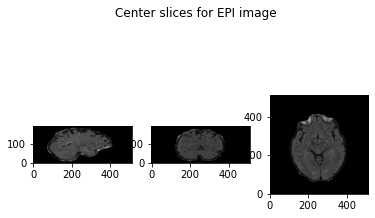

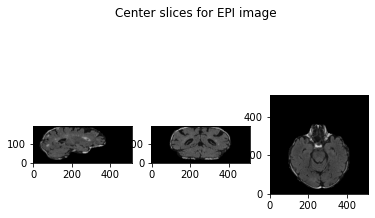

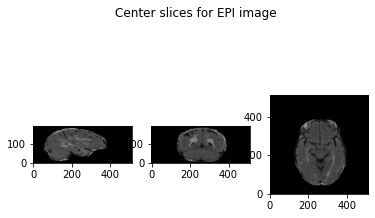

In [156]:
for i in range(3):
    img = X_test[i]['data'][0]
    slicing(img)

In [158]:
train_set, test_set = DataLoader(X_train, batch_size=2), DataLoader(X_test, batch_size=2)

In [164]:
"Simple neural network with one convolution and activation"
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = self._conv_layer_set(3, 32)
        self.conv2 = self._conv_layer_set(32,64)
        self.maxpool = nn.MaxPool3d(kernel_size=1)
        self.conv3 = self._conv_layer_set(64,1, nn.Sigmoid())
        
    def _conv_layer_set(self, in_c, out_c, activation = nn.ReLU()):
            conv_layer = nn.Sequential(
            nn.Conv3d(in_c, out_c, 1),
            activation,
            )
            return conv_layer

    def forward(self, x):
        x = x.float()
        print('1st convolution')
        out = self.conv1(x)
        print(out.shape)
        out=self.conv2(out)
        out = self.conv3(out)
        return out

In [165]:
tmp = next(iter(train_set))
print(tmp['data'].shape)
model = CNN()
out_img = model(tmp['data'])

torch.Size([2, 3, 512, 512, 192])
1st convolution


In [ ]:
print(out_img.shape)

Error: Session cannot generate requests